In [32]:
%load_ext autoreload
%autoreload 2

from krxns.net_construction import construct_reaction_network, extract_compounds
from krxns.config import filepaths
from krxns.utils import str2int
from krxns.cheminfo import draw_reaction
from krxns.networks import SuperMultiDiGraph
import json
from IPython.display import SVG

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Load unpaired cofactors
with open(filepaths['cofactors'] / 'expanded_unpaired_cofactors.json', 'r') as f:
    unpaired_cofactors = json.load(f)

# Load known reaction data
with open(filepaths['data'] / 'sprhea_240310_v3_mapped.json', 'r') as f:
    krs = json.load(f)

# Load op connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_operator.json', 'r') as f:
    op_cxns = str2int(json.load(f))

# Load sim connected reactions
with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_similarity.json', 'r') as f:
    sim_cxn = str2int(json.load(f))

with open(filepaths['connected_reactions'] / 'sprhea_240310_v3_mapped_side_counts.json', 'r') as f:
    side_counts = str2int(json.load(f))

# Load coreactant whitelist
with open(filepaths['cofactors'] / 'pickaxe_whitelist.json', 'r') as f:
    coreactant_whitelist = json.load(f)


# Get known compounds
kcs, smi2id = extract_compounds(krs)

In [34]:
G = SuperMultiDiGraph()
edges, nodes = construct_reaction_network(
    operator_connections=op_cxns,
    similarity_connections=sim_cxn,
    side_counts=side_counts,
    reactions=krs,
    unpaired_cofactors=unpaired_cofactors,
    connect_nontrivial=False,
    # atom_lb=0.6,
    coreactant_whitelist=coreactant_whitelist
)
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [38]:
def show_path(source, target, topk = 1):
    node_path, edge_path = G.shortest_path(source, target)
    for i, step in enumerate(edge_path):
        print(f"STEP #{i+1}")
        for edge in step[:topk]:
            print([(k, v) for k, v in edge.items() if k != 'smarts'])
            display(SVG(draw_reaction(edge['smarts'])))

STEP #1
[('rid', 1174), ('rhea_ids', [12654, 18366]), ('imt_rules', None), ('weight', 1), ('requires', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': 1, 'O=C=O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1})]


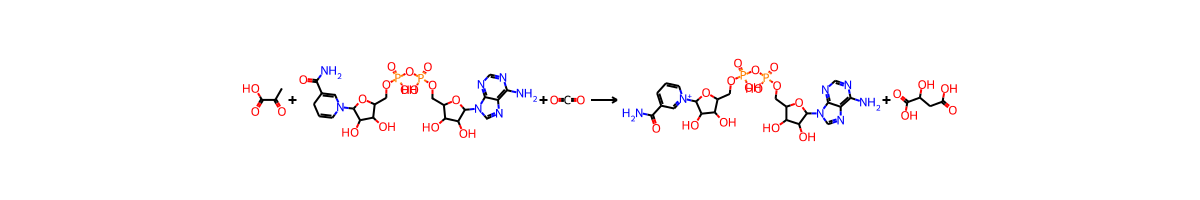

STEP #2
[('rid', 51), ('rhea_ids', [12462, 23694]), ('imt_rules', ['rule0020_18']), ('weight', 1.0), ('requires', {}), ('other_products', {'O': 1})]


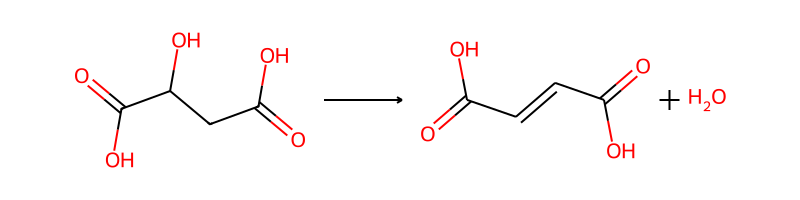

STEP #3
[('rid', 1638), ('rhea_ids', [40524]), ('imt_rules', ['rule0420_1']), ('weight', 1.0), ('requires', {'*c1c(*)c(O)c(*)c(*)c1O': 1}), ('other_products', {'*C1=C(*)C(=O)C(*)=C(*)C1=O': 1})]


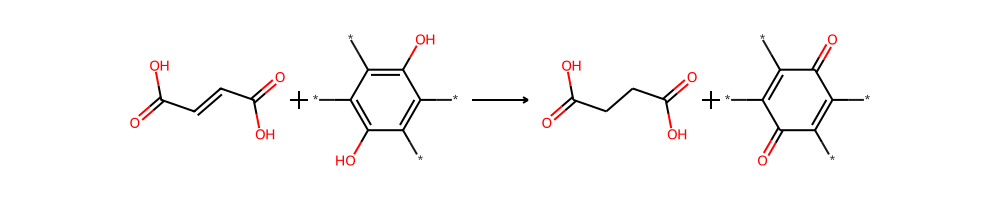

In [39]:
i = G.get_nodes_by_prop('name', 'pyruvate')[0]
j  = G.get_nodes_by_prop('name', 'succinate')[0]
show_path(i, j)

STEP #1
[('rid', 1638), ('rhea_ids', [40524]), ('imt_rules', ['rule0420_1']), ('weight', 1.0), ('requires', {'*C1=C(*)C(=O)C(*)=C(*)C1=O': 1}), ('other_products', {'*c1c(*)c(O)c(*)c(*)c1O': 1})]


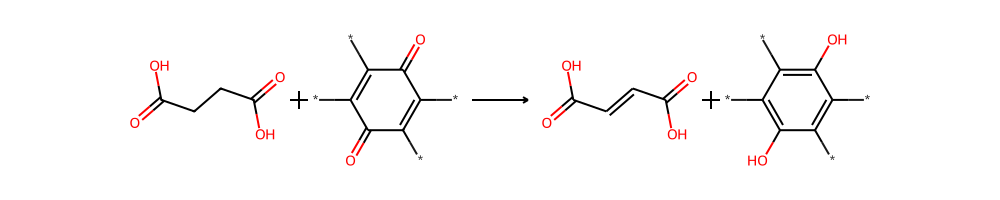

STEP #2
[('rid', 51), ('rhea_ids', [12462, 23694]), ('imt_rules', ['rule0020_18']), ('weight', 0.8888888888888888), ('requires', {'O': 1}), ('other_products', {})]


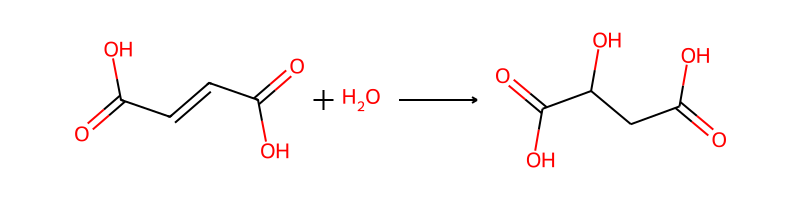

STEP #3
[('rid', 1174), ('rhea_ids', [12654, 18366]), ('imt_rules', None), ('weight', 1), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': 1, 'O=C=O': 1})]


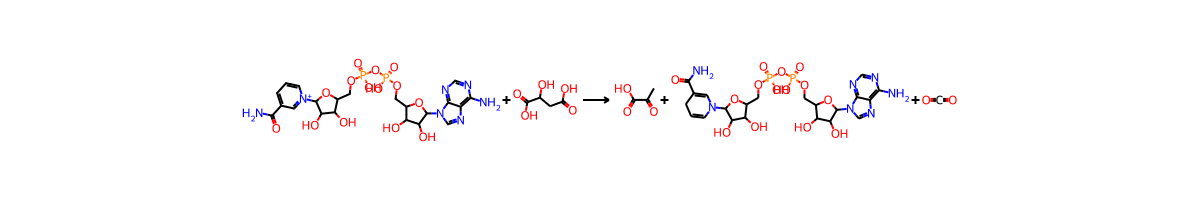

In [40]:
show_path(j, i)

STEP #1
[('rid', 410), ('rhea_ids', [40113]), ('imt_rules', ['rule0059_5']), ('weight', 0.09433962264150944), ('requires', {'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS': 1}), ('other_products', {'O': 1})]


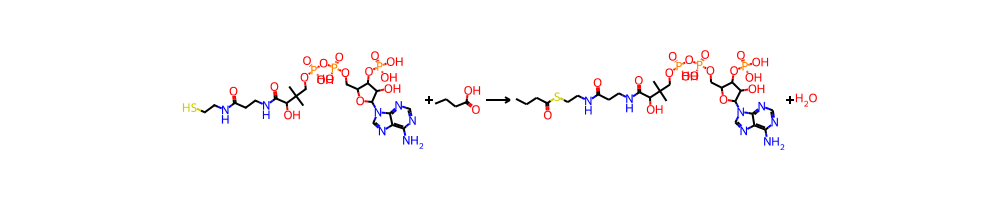

In [41]:
i = G.get_nodes_by_prop('name', 'butanoate')[0]
j  = G.get_nodes_by_prop('name', 'butanoyl-CoA')[0]
show_path(i, j)

STEP #1
[('rid', 12191), ('rhea_ids', [49637]), ('imt_rules', ['rule0145_5']), ('weight', 1.0), ('requires', {'OO': 1}), ('other_products', {'O': 1, 'O=O': 1})]


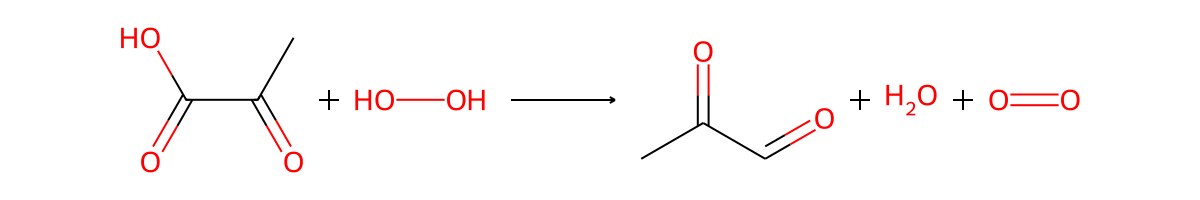

STEP #2
[('rid', 4467), ('rhea_ids', [27987]), ('imt_rules', ['rule0002_143']), ('weight', 1.0), ('requires', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1})]


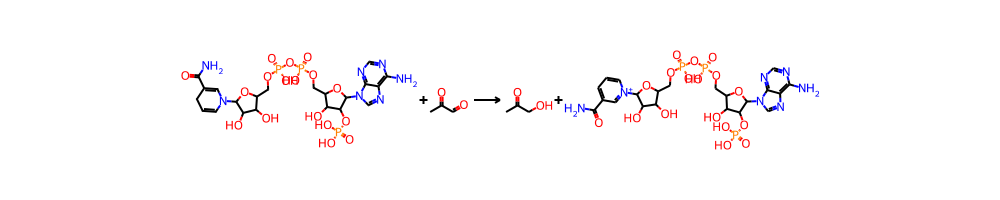

STEP #3
[('rid', 7031), ('rhea_ids', [55790]), ('imt_rules', ['rule0005_60']), ('weight', 1.0), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1, 'O': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': 1, 'O=O': 1})]


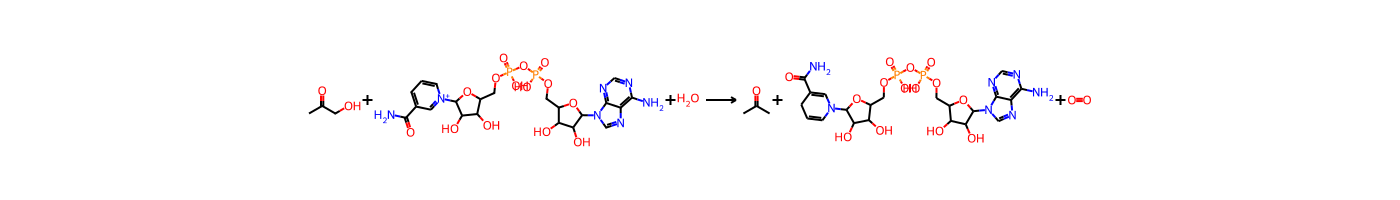

In [42]:
i = G.get_nodes_by_prop('name', 'pyruvate')[0]
j  = G.get_nodes_by_prop('name', 'acetone')[0]
show_path(i, j)

STEP #1
[('rid', 7031), ('rhea_ids', [55790]), ('imt_rules', ['rule0005_60']), ('weight', 0.8), ('requires', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1': 1, 'O=O': 1}), ('other_products', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1': 1, 'O': 1})]


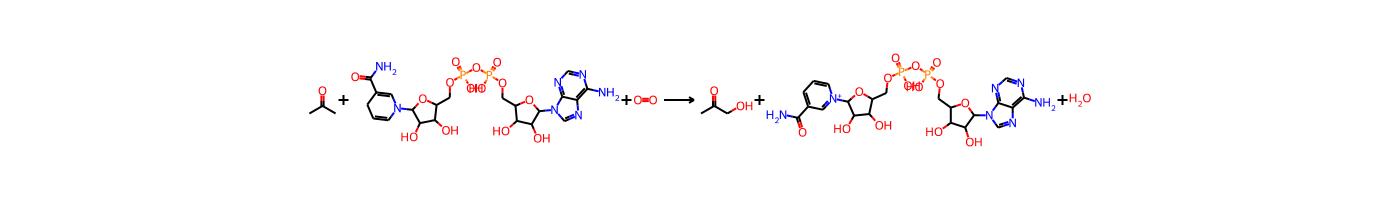

STEP #2
[('rid', 4467), ('rhea_ids', [27987]), ('imt_rules', ['rule0002_143']), ('weight', 1.0), ('requires', {'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1': 1}), ('other_products', {'NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1': 1})]


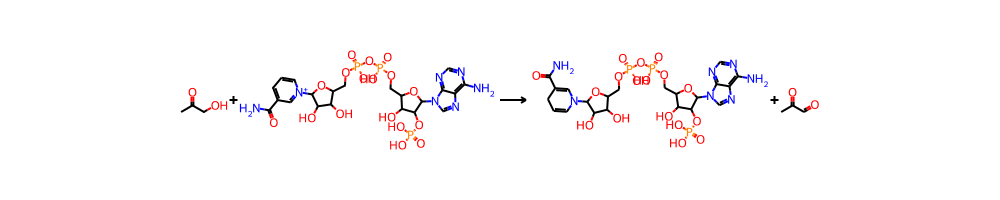

STEP #3
[('rid', 12191), ('rhea_ids', [49637]), ('imt_rules', ['rule0145_5']), ('weight', 0.8333333333333334), ('requires', {'O': 1, 'O=O': 1}), ('other_products', {'OO': 1})]


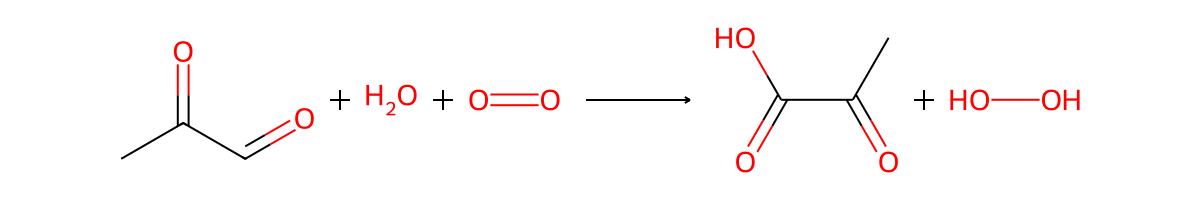

In [9]:
show_path(j, i)

In [10]:
# i = G.get_nodes_by_prop('name', 'pyruvate')[0]
# j  = G.get_nodes_by_prop('name', 'L-lysine')[0]
# show_path(i, j)

In [11]:
sorted([node['name'] for id, node in G.nodes(data=True)], key=lambda x : len(x))

['',
 '',
 '',
 '',
 '',
 'A',
 'CO',
 'Hg',
 'FMN',
 'FAD',
 'TDP',
 'TTP',
 'CMP',
 'CDP',
 'CTP',
 'GMP',
 'GDP',
 'GTP',
 'AMP',
 'ADP',
 'ATP',
 'XMP',
 'XDP',
 'XTP',
 'IMP',
 'IDP',
 'ITP',
 'UMP',
 'UDP',
 'UTP',
 'AH2',
 'dTMP',
 'dTTP',
 'NADH',
 'urea',
 'dCMP',
 'dCDP',
 'dCTP',
 'dZMP',
 'dZDP',
 'dZTP',
 'dGMP',
 'dGDP',
 'dGTP',
 'dAMP',
 'dADP',
 'dATP',
 'dIMP',
 'dIDP',
 'dITP',
 'dUMP',
 'dUTP',
 'taxol',
 'OPC-6',
 'SN-38',
 'FMNH2',
 'FADH2',
 'NADPH',
 'DIBOA',
 'urate',
 'Co(+)',
 'Cu(+)',
 'Lc4Cer',
 'ethene',
 'lupeol',
 'heme b',
 'alliin',
 'phytol',
 'citral',
 'baruol',
 'prenol',
 'sugiol',
 'lutein',
 'mogrol',
 'decane',
 'DIMBOA',
 'emodin',
 'thymol',
 'harmol',
 'biuret',
 'NAD(+)',
 'L-dopa',
 'A47934',
 "3'-CMP",
 "3'-GMP",
 "3'-AMP",
 'benzil',
 'biotin',
 'isatin',
 'uracil',
 'phenol',
 'Co(2+)',
 'Cr(3+)',
 'Cr(6+)',
 'Cu(2+)',
 'Hg(2+)',
 'iodide',
 'Mg(2+)',
 'Mn(2+)',
 'Mn(3+)',
 'Ni(2+)',
 'indole',
 'a thiol',
 'methane',
 'kainate',
 'taxu

In [12]:
# smi = standardize_smiles('CC(C)(CO)[C@@H](O)C(=O)NCCC(=O)[O-]') # CCC(C)(C)C(=O)SCCC(=O)OC
# ids = G.get_nodes_by_prop('smiles', smi)
# ids

In [13]:
# n = 2
# id = ids[0]
# n_hop_neighbors = nx.ego_graph(G, id, radius=n)
# for i in n_hop_neighbors:
#     print(G.nodes[i]['name'])
#     display(SVG(draw_molecule(G.nodes[i]['smiles'])))

In [14]:
# for i in n_hop_neighbors:
#     print(f"PATH FROM {G.nodes[i]['name']}")
#     show_path(i, id)